# Interannual variability and seasonality in NMEG sites

In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pdb as pdb

%matplotlib inline
sns.set_style("white")

/home/greg/data/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [7]:
data_path = '~/data/current/NMEG_utils/processed_data/daily_aflx/'
fig_path = './figures/multiyr_figs/'
# Years to load
start = 2007
end = 2015
# Sites to load (pulls list of AF sites from plot_nmeg module)
sites = ['Seg', 'Ses', 'Wjs', 'Mpj','Vcp', 'Vcm']
# Fill a dict with multiyear dataframes for each site in sites
daily = { x : 
         ld.load_local_file( data_path + 'US-' + x + '_daily_aflx.csv')
         for x in sites }
d = pd.Panel(daily)

Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Seg_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Ses_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Wjs_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Mpj_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcp_daily_aflx.csv
Parsing ~/data/current/NMEG_utils/processed_data/daily_aflx/US-Vcm_daily_aflx.csv


In [16]:
# Plot definition for a 3 x 2 plot of multiyear mean data
def plot_multiyr_mean_sites( clim_in, clim_cols, varname, texty, fighandle, errcol=None,
                            xlims=[0,366], ylims=[-10,10], sitelist=sites,
                            sitenames=nmegplt.longnames, colors=nmegplt.palette ):
    if type(clim_in) is list:
        clim = clim_in[0]
        clim2 = clim_in[1]
    else:
        clim = clim_in
        
    ax = list();
    for i, site in enumerate(sitelist):
        ax.append(fighandle.add_subplot(3, 2, i+1))
        plt.plot( xlims, [0, 0], ':k')
        ax[i].plot(clim[site].index, clim[site][clim_cols], color=colors[site], lw=1)
        if errcol is not None:
            ax[i].plot(clim[site].index, clim[site][clim_cols]+clim[site][errcol], 
                       color='0.6', lw=0.5)
            ax[i].plot(clim[site].index, clim[site][clim_cols]-clim[site][errcol], 
                       color='0.6', lw=0.5)
        if type(clim_in) is list:
            ax[i].plot(clim2[site].index, -clim2[site][clim_cols], color=colors[site], lw=1)
            if errcol is not None:
                ax[i].plot(clim2[site].index, -clim2[site][clim_cols]+clim2[site][errcol], 
                           color='0.6', lw=0.5)
                ax[i].plot(clim2[site].index, -clim2[site][clim_cols]-clim2[site][errcol], 
                           color='0.6', lw=0.5)
            
        plt.ylim( ylims )
        plt.xlim( xlims )
        plt.text( 10, texty, sitenames[site], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        #ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))
        if i < 4:
            plt.setp( ax[i].get_xticklabels(), visible=False)
        else:
            plt.setp( ax[i].get_xticklabels(), fontsize=14)
            
    for i in (0, 2, 4):
        ax[i].set_ylabel(varname, fontsize=14)
        
    return ax

In [4]:
# Function for adding rolling sum to a climatology
def add_rollsum( clim ):
    clim_out = clim.copy()
    # Subset climatology to desired years
    yrs = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
    clim_subset = clim.loc[:,yrs]
    # Melt dataframe so values are in year,day order
    clim_subset['days'] = clim_subset.index
    clim_melt = pd.melt(clim_subset, id_vars=['days'], value_vars=yrs)
    # Copy melted dataframe and calculate rolling sum
    rollsum = clim_melt.copy()
    rollsum.value = clim_melt.value.rolling(window=30, min_periods=27).sum()
    # Now pivot back into columnar data
    clim_sum = rollsum.pivot(index='days', columns='variable')['value']
    
    # Get summary stats for each day of the year
    clim_out[ 'sum30d_mean' ] = clim_sum.mean(axis=1)
    clim_out[ 'sum30d_stdev' ] = clim_sum.std(axis=1)
    clim_out[ 'sum30d_cv' ] = clim_out.sum30d_stdev / clim_out.sum30d_mean
    clim_out[ 'sum_30d_cv2' ] = clim_out.sum30d_stdev / clim_melt.value.mean()
    return clim_out

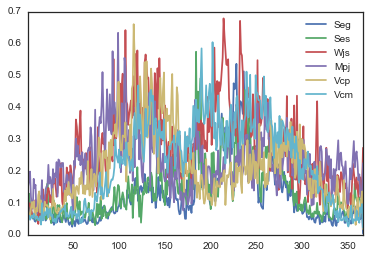

In [5]:
fc_clim, fc_clim_adj, gpp_clim, re_clim, p_clim, vpd_clim = dict(), dict(), dict(), dict(), dict(), dict()

for site in sites:
    fc_clim[ site ] = tr.var_climatology( daily[ site ].FC_F_g_int )
    fc_clim_adj[ site ] = tr.var_climatology( daily[ site ].FC_F_g_int + np.abs(daily[ site ].FC_F_g_int.min()))
    gpp_clim[ site ] = tr.var_climatology( daily[ site ].GPP_g_int )
    re_clim[ site ] = tr.var_climatology( daily[ site ].RECO_g_int )
    p_clim[ site ] = add_rollsum(tr.var_climatology( daily[ site ].P_F_sum ))
    vpd_clim[ site ] = tr.var_climatology( daily[ site ].VPD_F_avg )
    fc_clim_adj[site].allyr_cv.plot()
    #re_clim[site].allyr_cv.rolling(window=30, center=True).mean().plot()
plt.legend(sites)
#p_clim['Mpj'].head()

## Plot means and standard deviation

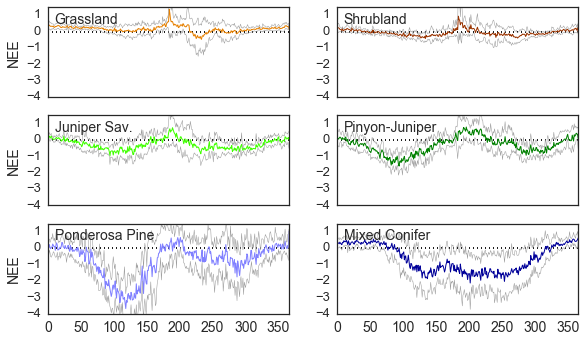

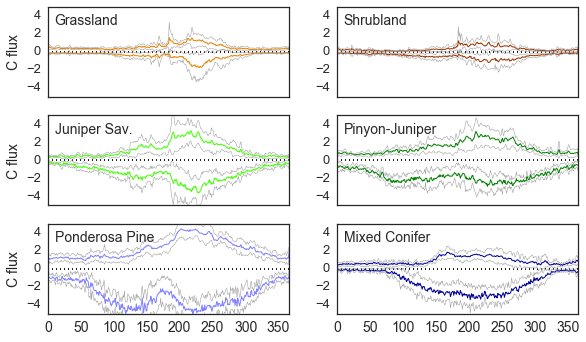

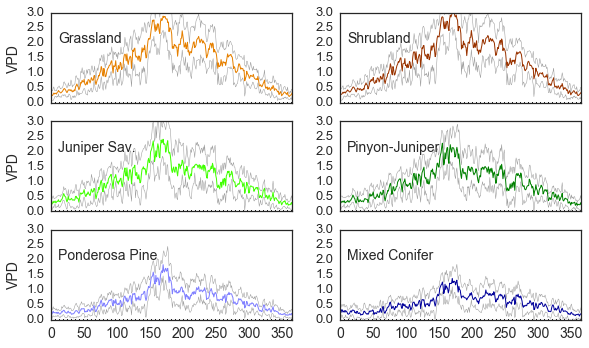

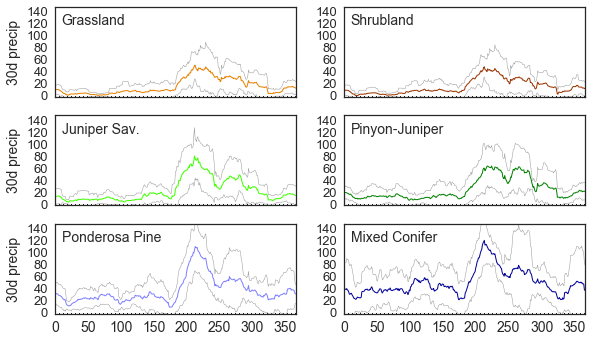

In [21]:
ylims = [ -4, 1.5 ]
xlims = [ 0, 366 ]
#highlight_year = [2011]
fig1 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim, 'allyr_mean', 'NEE', 0.5, fig1, errcol='allyr_stdev',
                        ylims=ylims)
ylims = [ -5, 5 ]
fig2 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( [re_clim, gpp_clim], 'allyr_mean', 'C flux', 3, fig2, errcol='allyr_stdev',
                        ylims=ylims)
ylims = [ 0, 3 ]
fig3 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( vpd_clim, 'allyr_mean', 'VPD', 2, fig3, errcol='allyr_stdev',
                        ylims=ylims)
ylims = [ 0, 150 ]
fig4 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( p_clim, 'sum30d_mean', '30d precip', 120, fig4, errcol='sum30d_stdev',
                        ylims=ylims)

fig1.savefig( fig_path + 'NMEG_meanvar_NEE.svg')
fig2.savefig( fig_path + 'NMEG_meanvar_Cpart.svg')
fig4.savefig( fig_path + 'NMEG_meanvar_P.svg')

## Plot coefficient of variation

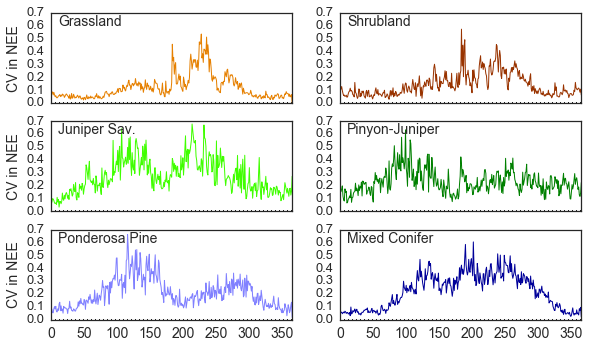

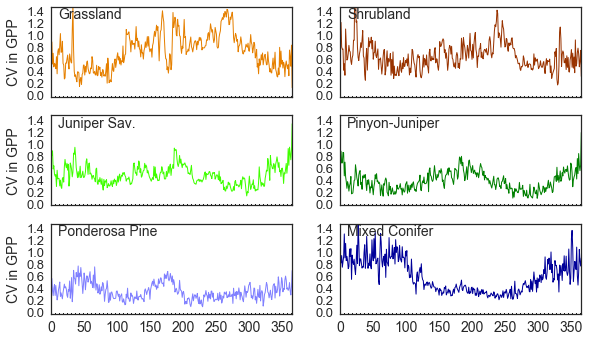

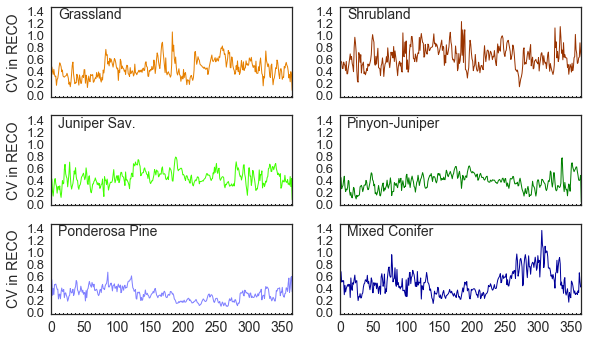

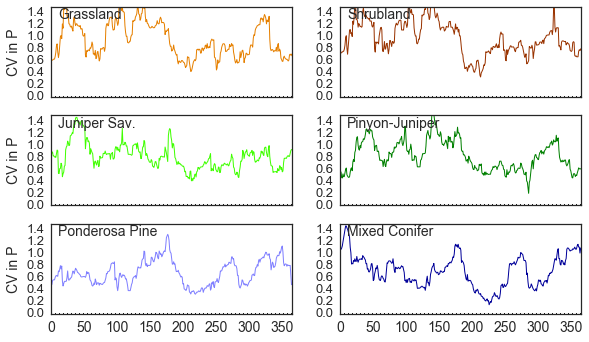

In [18]:
ylims = [ 0, 0.7 ]
fig1 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim_adj, 'allyr_cv', 'CV in NEE', 0.6, fig1,
                        ylims=ylims)
ylims = [ 0, 1.5 ]
fig2 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( gpp_clim, 'allyr_cv', 'CV in GPP', 1.3, fig2,
                        ylims=ylims)
fig3 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( re_clim, 'allyr_cv', 'CV in RECO', 1.3, fig3,
                        ylims=ylims)
fig4 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( p_clim, 'sum30d_cv', 'CV in P', 1.3, fig4,
                        ylims=ylims)

fig1.savefig( fig_path + 'NMEG_CV_NEE.svg')
fig4.savefig( fig_path + 'NMEG_CV_P.svg')

## CV using allyear mean

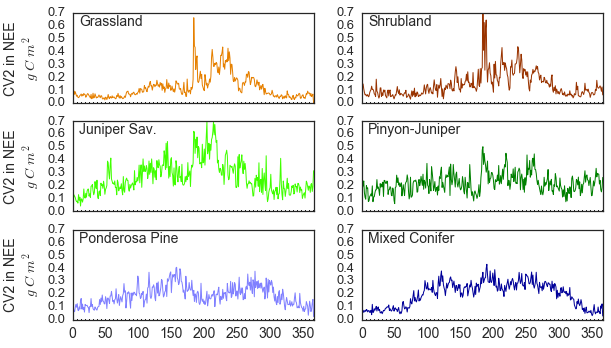

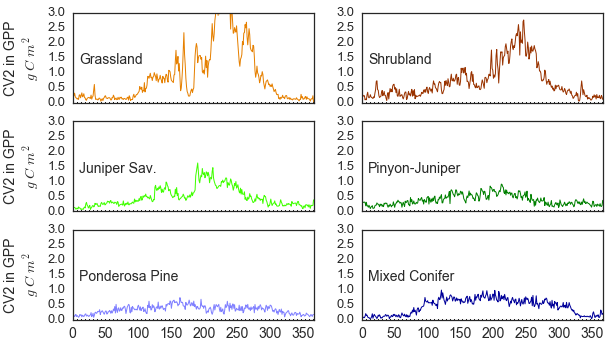

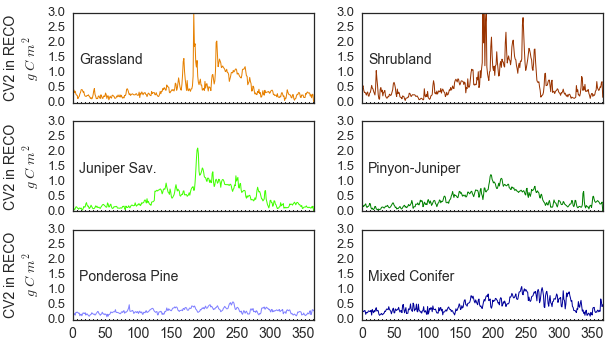

In [46]:
ylims = [ 0, 0.7 ]
fig1 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim_adj, 'allyr_cv2', 'CV2 in NEE', 0.6, fig1,
                        ylims=ylims)
ylims = [ 0, 3 ]
fig2 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( gpp_clim, 'allyr_cv2', 'CV2 in GPP', 1.3, fig2,
                        ylims=ylims)
fig3 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( re_clim, 'allyr_cv2', 'CV2 in RECO', 1.3, fig3,
                        ylims=ylims)

## Soil data

In [10]:
soil_path = '/home/greg/data/current/NMEG_utils/processed_data/daily_soilmet/'
soil_d = { x : 
         ld.load_local_file( soil_path + 'US-' + x + '_daily_soilmet.csv' )
         for x in sites }
s = pd.Panel(soil_d)

Parsing /home/greg/data/current/NMEG_utils/processed_data/daily_soilmet/US-Seg_daily_soilmet.csv
Parsing /home/greg/data/current/NMEG_utils/processed_data/daily_soilmet/US-Ses_daily_soilmet.csv
Parsing /home/greg/data/current/NMEG_utils/processed_data/daily_soilmet/US-Wjs_daily_soilmet.csv
Parsing /home/greg/data/current/NMEG_utils/processed_data/daily_soilmet/US-Mpj_daily_soilmet.csv
Parsing /home/greg/data/current/NMEG_utils/processed_data/daily_soilmet/US-Vcp_daily_soilmet.csv
Parsing /home/greg/data/current/NMEG_utils/processed_data/daily_soilmet/US-Vcm_daily_soilmet.csv


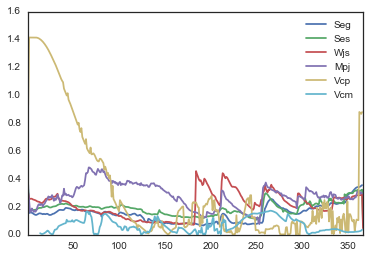

In [11]:
shall_clim, mid_clim, deep_clim = dict(), dict(), dict()

for site in sites:
    shall_clim[ site ] = tr.var_climatology( soil_d[ site ].shall_swc_interp )
    mid_clim[ site ] = tr.var_climatology( soil_d[ site ].mid_swc_interp )
    deep_clim[ site ] = tr.var_climatology( soil_d[ site ].deep_swc_interp )
    deep_clim[site].allyr_cv.plot()
    #re_clim[site].allyr_cv.rolling(window=30, center=True).mean().plot()
plt.legend(sites)
#p_clim['Mpj'].head()

## Plot means and standard deviation

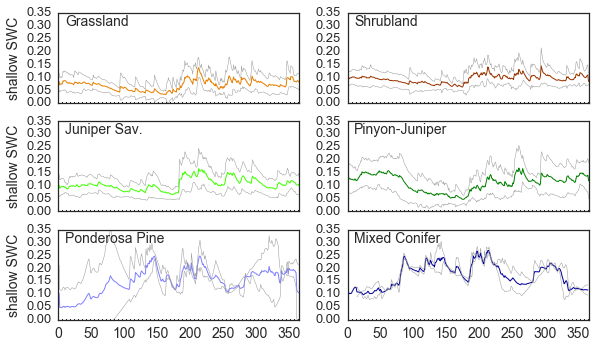

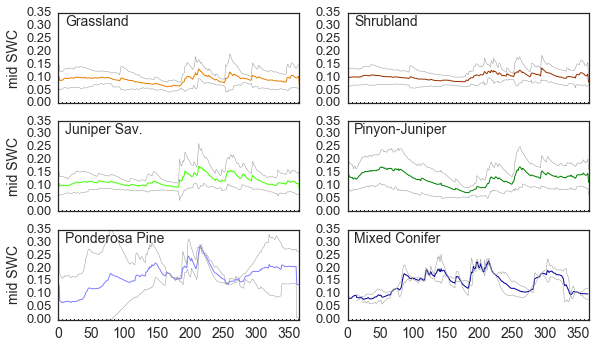

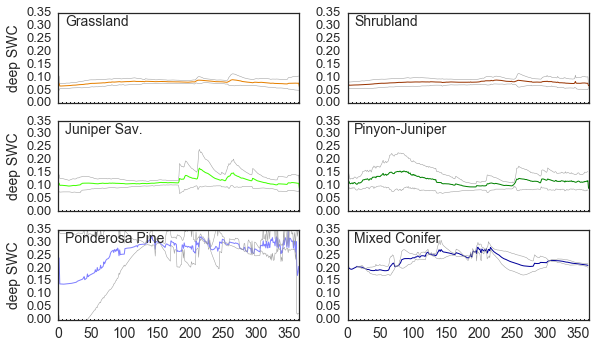

In [19]:
ylims = [ 0, .35 ]
xlims = [ 0, 366 ]
#highlight_year = [2011]
fig1 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( shall_clim, 'allyr_mean', 'shallow SWC', 0.3, fig1, errcol='allyr_stdev',
                        ylims=ylims)

fig2 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( mid_clim, 'allyr_mean', 'mid SWC', 0.3, fig2, errcol='allyr_stdev',
                        ylims=ylims)

fig3 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( deep_clim, 'allyr_mean', 'deep SWC', 0.3, fig3, errcol='allyr_stdev',
                        ylims=ylims)

fig2.savefig( fig_path + 'NMEG_meanvar_SWCmid.svg')

## Plot CV

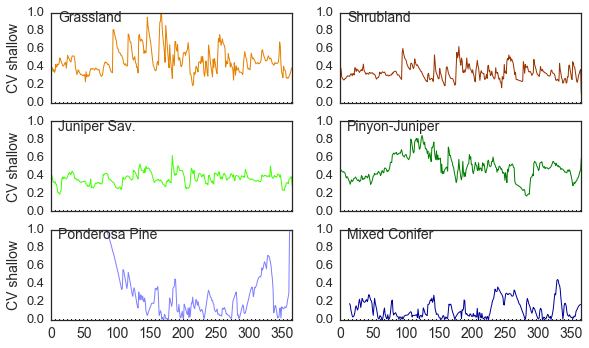

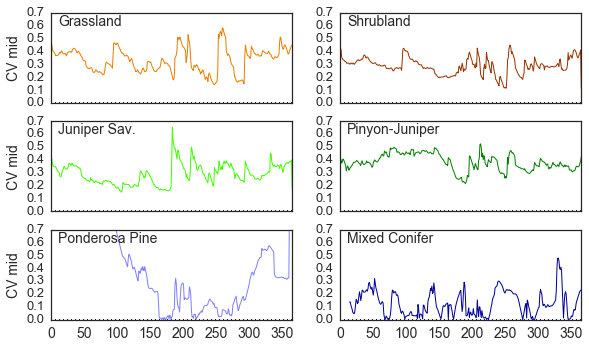

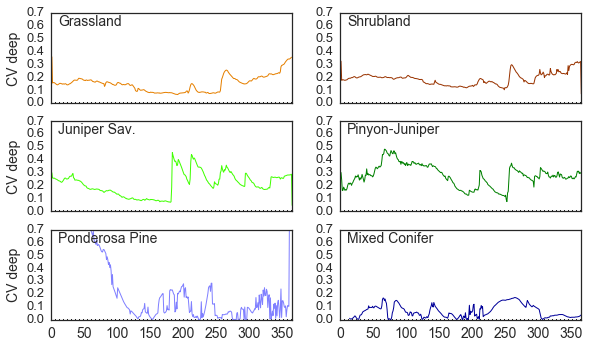

In [23]:
ylims = [ 0, 1 ]
fig1 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( shall_clim, 'allyr_cv', 'CV shallow', 0.9, fig1,
                        ylims=ylims)
ylims = [ 0, 0.7 ]
fig2 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( mid_clim, 'allyr_cv', 'CV mid', 0.6, fig2,
                        ylims=ylims)
fig3 = plt.figure(figsize=( 9.5, 5.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( deep_clim, 'allyr_cv', 'CV deep', 0.6, fig3,
                        ylims=ylims)

fig3.savefig( fig_path + 'NMEG_CV_SWCdeep.svg')